# Predição de Preços de Casas com Redes Neurais
## Trabalho RNA
### Alunos: Victor Shin Iti Kanazawa Noda, Lara Portilho Marques, Joao Victor Araujo Costa

Este notebook apresenta a implementação de redes neurais para a predição de preços de casas, utilizando o dataset "House Prices" do Kaggle. O objetivo é aplicar técnicas de aprendizado de máquina para estimar o valor de venda de imóveis residenciais a partir de suas características, incluindo etapas de pré-processamento, construção e treinamento de modelos, avaliação de desempenho e geração de predições para submissão.

## 1. Importações de Bibliotecas e Configurações de Visualização

In [2]:
# Importações básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import os
from datetime import datetime

# PyTorch para redes neurais
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn para pré-processamento e métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Configurações de visualização
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_palette("husl")

In [3]:
# Configurações gerais
SEED = 42
TARGET_COL = 'SalePrice'
VAL_SIZE = 0.2

# Configurar seeds para reprodutibilidade
np.random.seed(SEED)
torch.manual_seed(SEED)

# Configurar dispositivo (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilizando dispositivo: {device.type.upper()}")
print(f"Seed configurada: {SEED}")

# Criar pasta para salvar resultados
results_dir = 'resultados_modelos'
os.makedirs(results_dir, exist_ok=True)
print(f"Pasta criada para resultados: {results_dir}/")

Utilizando dispositivo: CPU
Seed configurada: 42
Pasta criada para resultados: resultados_modelos/


## 2. Carregamento e Análise dos Dados

Dados de treinamento carregados com sucesso!
   - Amostras: 1460
   - Features: 81


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


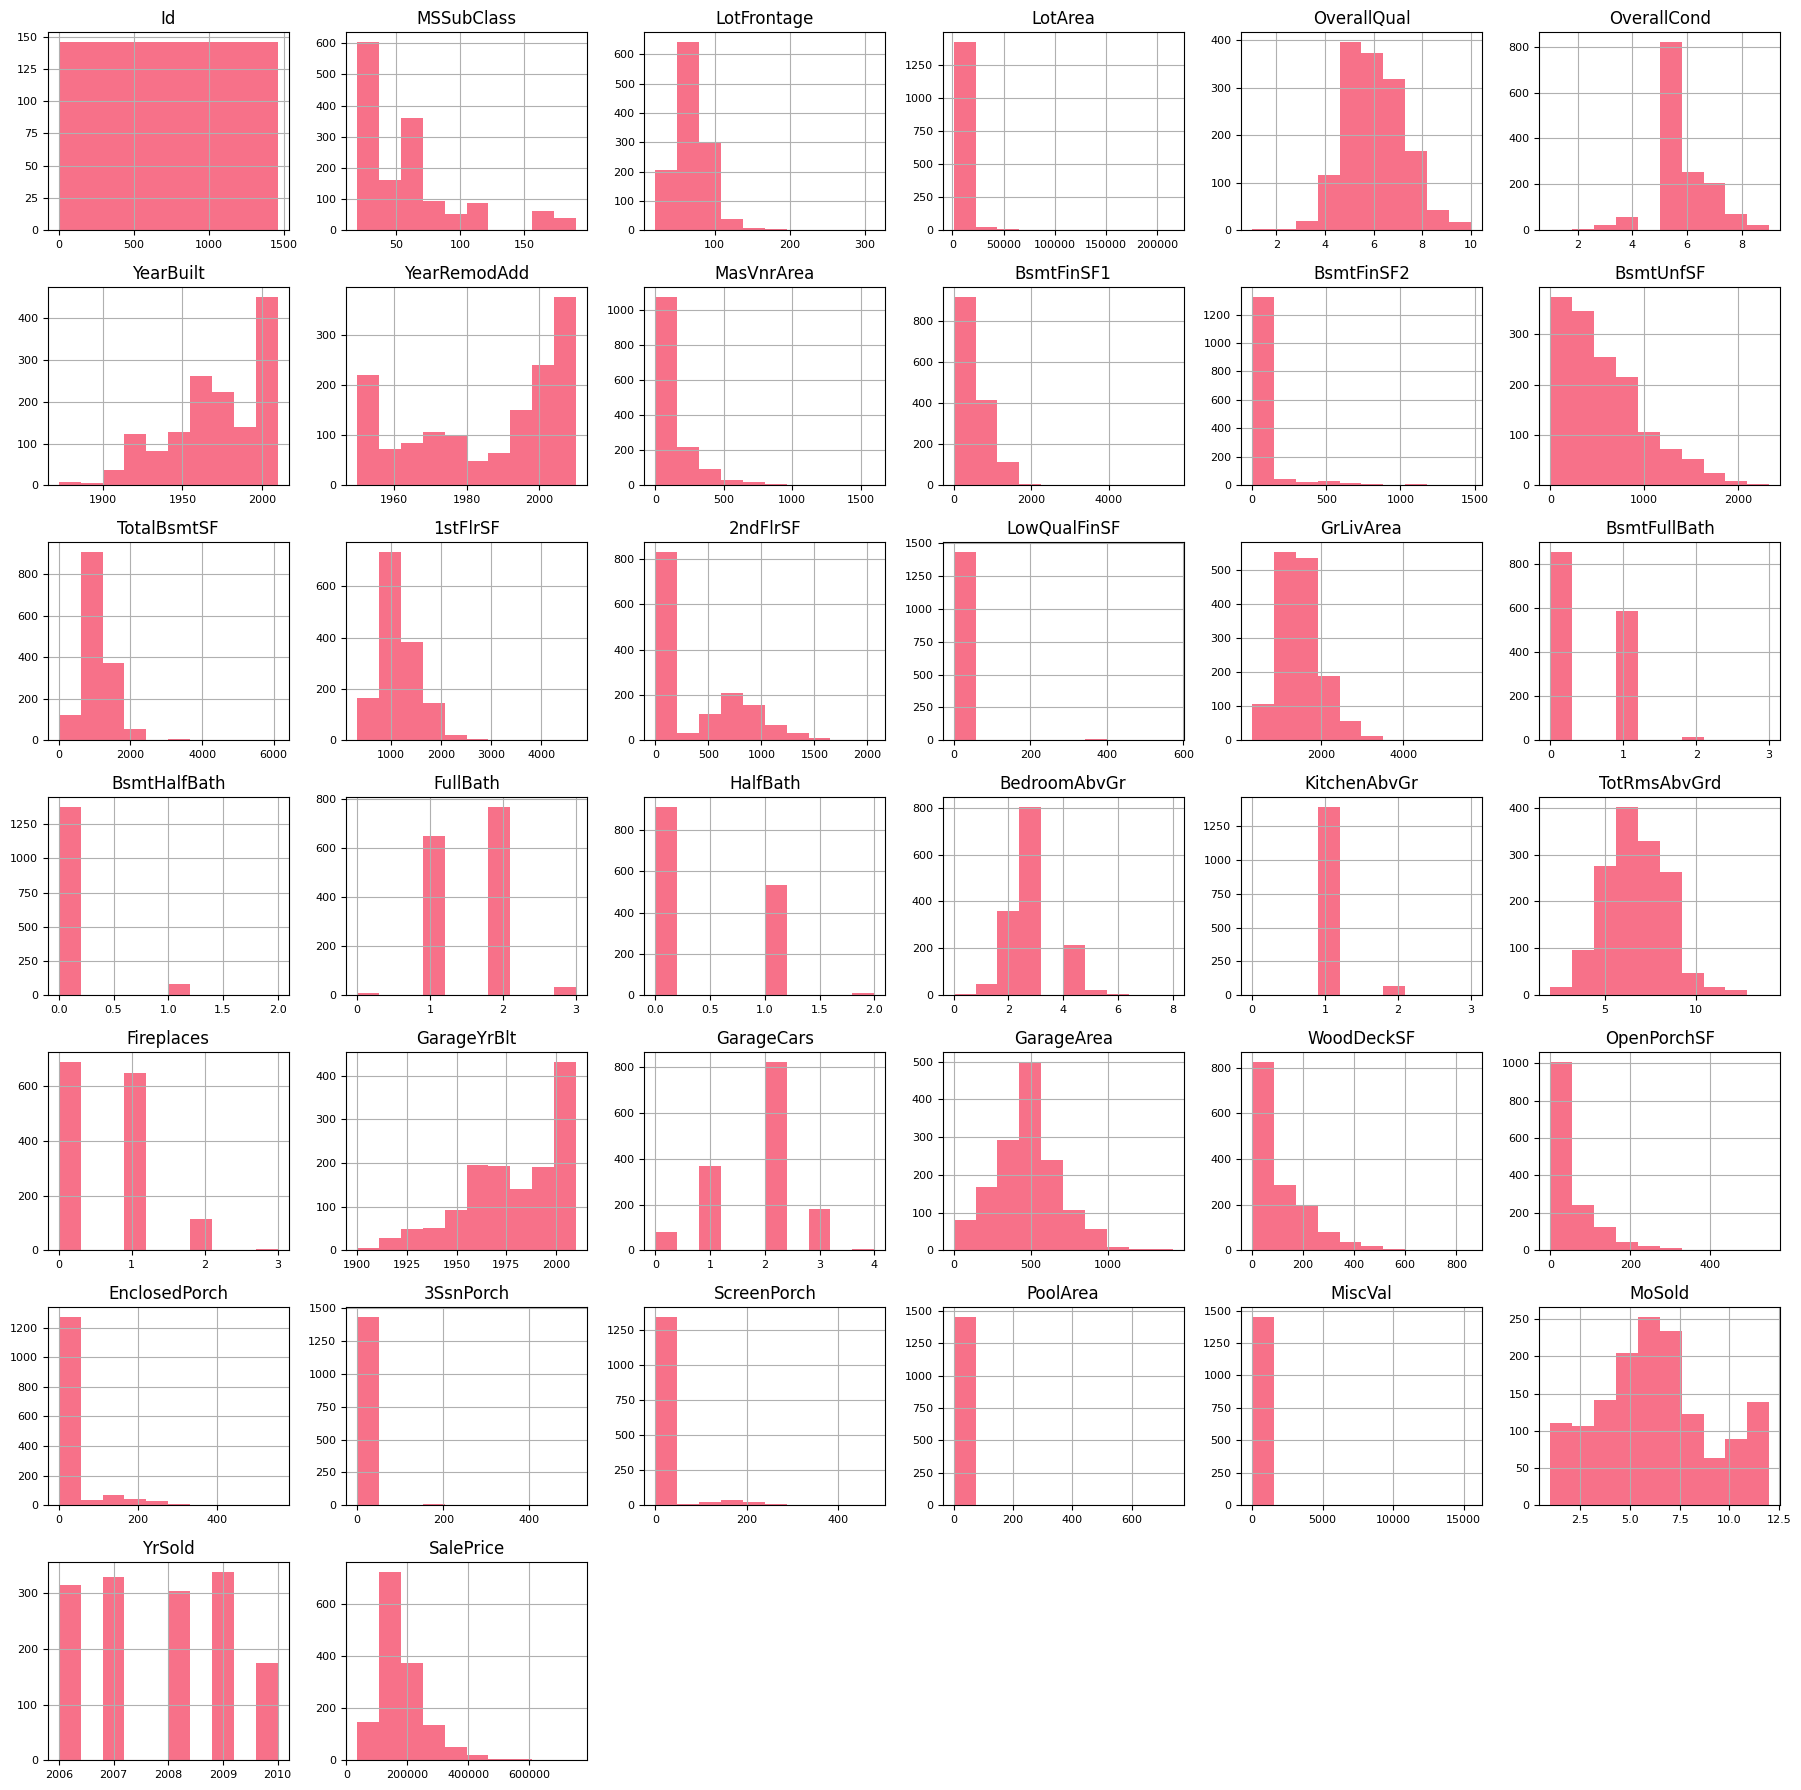


Informações sobre SalePrice:
   - Preço mínimo: $34,900
   - Preço máximo: $755,000
   - Preço médio: $180,921
   - Preço mediano: $163,000


In [4]:
# Carregar dados
df = pd.read_csv('train.csv')
print(f"Dados de treinamento carregados com sucesso!")
print(f"   - Amostras: {df.shape[0]}")
print(f"   - Features: {df.shape[1]}")
data_source = 'real'

# Mostrar primeiras linhas
display(df.head())
df.hist(figsize=(18, 18), xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()
# Informações básicas sobre o target
print(f"\nInformações sobre {TARGET_COL}:")
print(f"   - Preço mínimo: ${df[TARGET_COL].min():,.0f}")
print(f"   - Preço máximo: ${df[TARGET_COL].max():,.0f}")
print(f"   - Preço médio: ${df[TARGET_COL].mean():,.0f}")
print(f"   - Preço mediano: ${df[TARGET_COL].median():,.0f}")

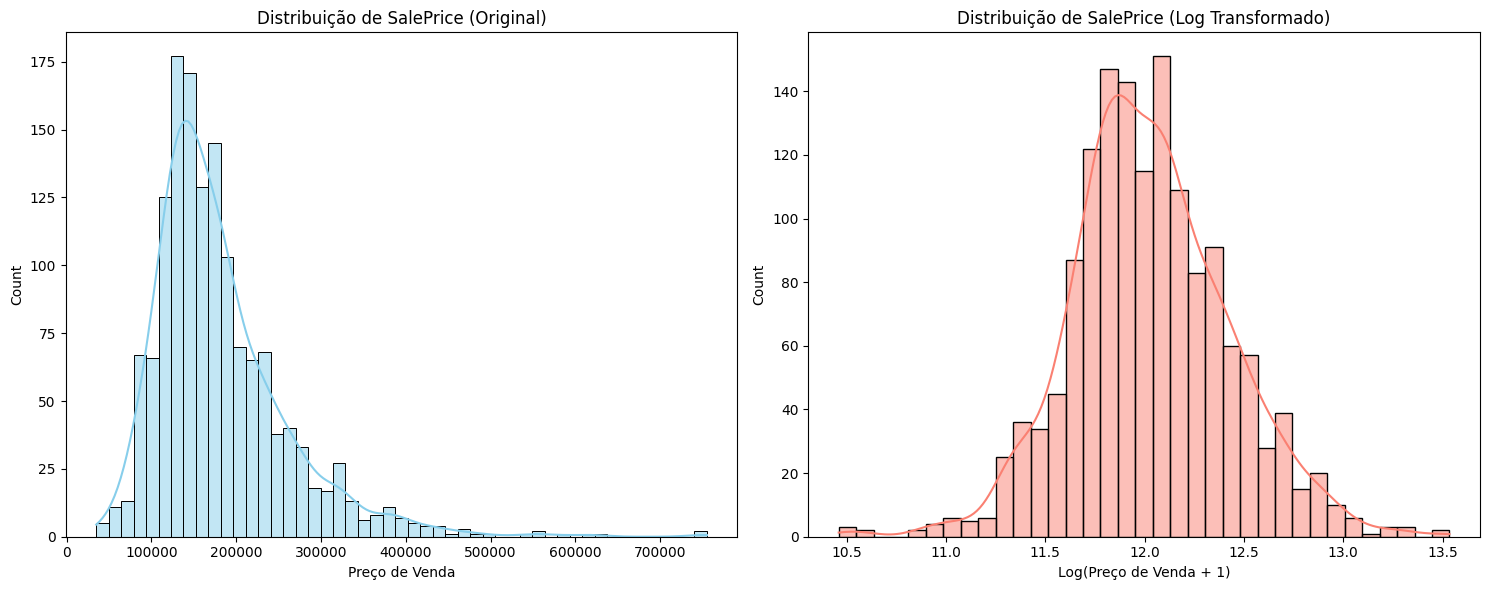

SalePrice transformado com np.log1p para melhor distribuição.

Top 10 Features mais correlacionadas com SalePriceLog:


SalePriceLog    1.000000
SalePrice       0.948374
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: SalePriceLog, dtype: float64

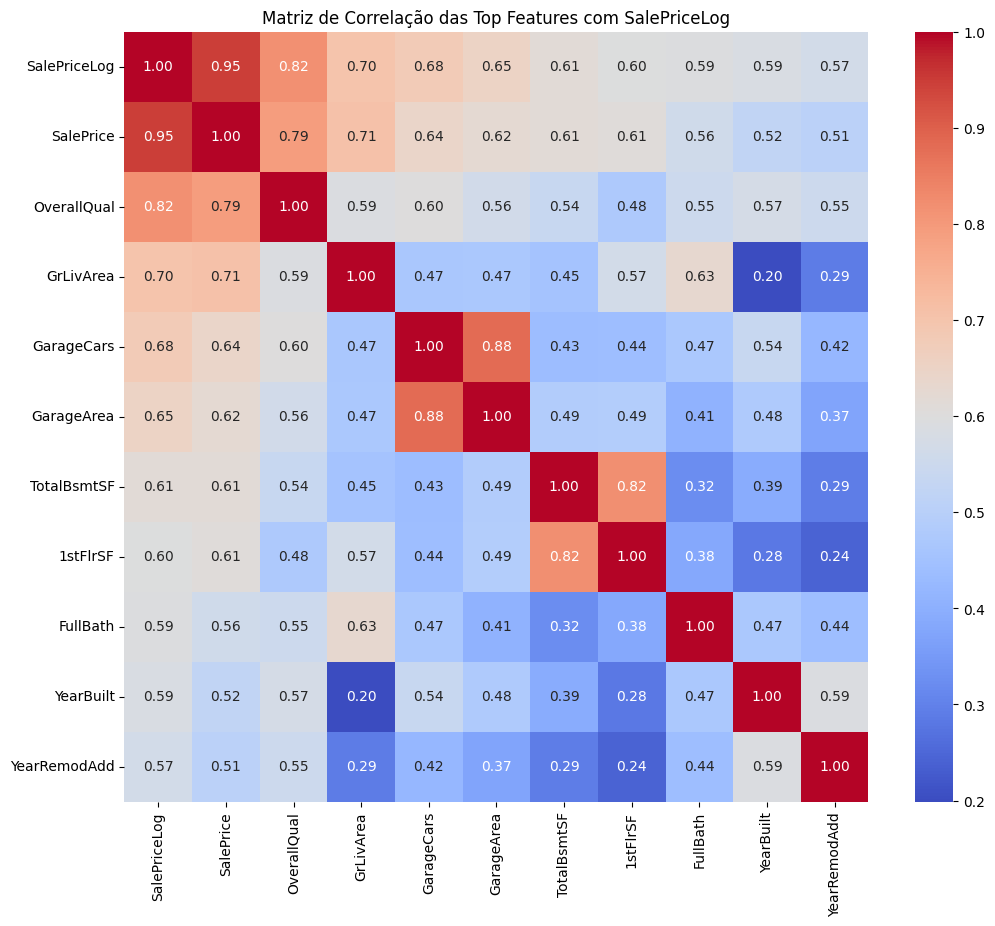


Colunas com mais Valores Ausentes no Dataset de Treino (Top 20):


,Total Ausente,% Ausente
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageCond,81,5.547945


In [5]:
# Análise exploratória básica

# Visualização da distribuição do SalePrice
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Distribuição original
sns.histplot(df['SalePrice'], kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribuição de SalePrice (Original)')
axes[0].set_xlabel('Preço de Venda')

# Aplicando transformação logarítmica
df['SalePriceLog'] = np.log1p(df['SalePrice'])
sns.histplot(df['SalePriceLog'], kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Distribuição de SalePrice (Log Transformado)')
axes[1].set_xlabel('Log(Preço de Venda + 1)')

plt.tight_layout()
plt.show()
print("SalePrice transformado com np.log1p para melhor distribuição.")

# Correlação com o SalePriceLog
numeric_features_train = df.select_dtypes(include=np.number)
correlation_matrix_log = numeric_features_train.corr()
target_correlation_log = correlation_matrix_log['SalePriceLog'].sort_values(ascending=False)
print("\nTop 10 Features mais correlacionadas com SalePriceLog:")
display(target_correlation_log.head(11))

# Matriz de correlação das top features
top_features = target_correlation_log.index[:11]
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Top Features com SalePriceLog')
plt.show()

# Análise de valores ausentes
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_data = pd.concat([missing_values, missing_percent], axis=1, keys=['Total Ausente', '% Ausente'])
print("\nColunas com mais Valores Ausentes no Dataset de Treino (Top 20):")
display(missing_data[missing_data['Total Ausente'] > 0].head(20))

## 3. Pré-processamento Simplificado

Limpa os dados,
Preenche valores ausentes,
Codifica variáveis categóricas,
Prepara os dados para serem usados

In [6]:
def preprocess_data_simple(df):
    """Pré-processamento simplificado dos dados"""
    
    # Fazer uma cópia para não modificar o original
    df_processed = df.copy()
    
    # Remover colunas com muitos valores ausentes (>50%)
    missing_percent = df_processed.isnull().sum() / len(df_processed)
    cols_to_drop = missing_percent[missing_percent > 0.5].index.tolist()
    df_processed = df_processed.drop(columns=cols_to_drop)
    print(f"   - Removidas {len(cols_to_drop)} colunas com muitos valores ausentes")
    
    # Separar features numéricas e categóricas
    numeric_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()
    
    # Remover Id e target das features
    if 'Id' in numeric_features:
        numeric_features.remove('Id')
    if TARGET_COL in numeric_features:
        numeric_features.remove(TARGET_COL)
    
    print(f"   - Features numéricas: {len(numeric_features)}")
    print(f"   - Features categóricas: {len(categorical_features)}")
    
    # Preencher valores ausentes
    # Numéricas: preencher com mediana
    for col in numeric_features:
        median_val = df_processed[col].median()
        if pd.isna(median_val):  # Se a mediana também for NaN
            median_val = 0.0
        df_processed[col] = df_processed[col].fillna(median_val)
    
    # Categóricas: preencher com moda
    for col in categorical_features:
        df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown')
    
    # Codificar variáveis categóricas (Label Encoding simples)
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
    
    # Selecionar apenas as features que vamos usar
    feature_columns = numeric_features + categorical_features
    X = df_processed[feature_columns]
    y = df_processed[TARGET_COL]
    
    # Aplicar transformação logarítmica no target
    y_log = np.log1p(y)
    
    print(f"   - Shape final: X{X.shape}, y{y.shape}")
    print("Pré-processamento concluído!")
    
    return X, y_log, y, feature_columns, label_encoders

# Executar pré-processamento
if not df.empty:
    X, y_log, y_original, feature_columns, encoders = preprocess_data_simple(df)
else:
    print("Dados não disponíveis para pré-processamento")
    X, y_log, y_original = None, None, None

   - Removidas 5 colunas com muitos valores ausentes
   - Features numéricas: 37
   - Features categóricas: 38
   - Shape final: X(1460, 75), y(1460,)
Pré-processamento concluído!


## 4. Divisão dos Dados e Normalização

In [7]:
if X is not None and y_log is not None:
    # Dividir dados em treino e validação
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_log, test_size=VAL_SIZE, random_state=SEED
    )
    
    print(f"Divisão dos dados:")
    print(f"   - Treino: {X_train.shape[0]} amostras")
    print(f"   - Validação: {X_val.shape[0]} amostras")
    print(f"   - Features: {X_train.shape[1]}")
    
    # Normalizar features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Converter para tensors PyTorch
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1).to(device)
    X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
    y_val_tensor = torch.FloatTensor(y_val.values).view(-1, 1).to(device)
    
    print(f"Dados normalizados e convertidos para tensors PyTorch")
    print(f"   - X_train_tensor: {X_train_tensor.shape}")
    print(f"   - y_train_tensor: {y_train_tensor.shape}")
else:
    print("Não é possível dividir os dados")

Divisão dos dados:
   - Treino: 1168 amostras
   - Validação: 292 amostras
   - Features: 75
Dados normalizados e convertidos para tensors PyTorch
   - X_train_tensor: torch.Size([1168, 75])
   - y_train_tensor: torch.Size([1168, 1])


## 5. Definição da Rede Neural

In [8]:
class SimpleNeuralNetwork(nn.Module):
    """Rede Neural Simples para Regressão"""
    
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.2):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Lista para armazenar as camadas
        layers = []
        
        # Primeira camada
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Camadas ocultas
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Camada de saída
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        # Criar o modelo sequencial
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

print("Classe SimpleNeuralNetwork definida!")
print("   - Usa ReLU como função de ativação")
print("   - Inclui Dropout para regularização")
print("   - Arquitetura flexível (pode ter várias camadas ocultas)")

Classe SimpleNeuralNetwork definida!
   - Usa ReLU como função de ativação
   - Inclui Dropout para regularização
   - Arquitetura flexível (pode ter várias camadas ocultas)


## 6. Função de Treinamento

In [9]:
def train_model(model, X_train, y_train, X_val, y_val, config):
    """Função para treinar o modelo"""
    
    # Configurações do treinamento
    learning_rate = config['learning_rate']
    num_epochs = config['num_epochs']
    weight_decay = config.get('weight_decay', 0)  # L2 regularization
    
    # Otimizador e função de perda
    optimizer_type = config.get('optimizer_type', 'adam')  # Default para Adam
    if optimizer_type.lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    else:  # adam
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    
    # Listas para armazenar o histórico
    train_losses = []
    val_losses = []
    
    print(f"Iniciando treinamento...")
    print(f"   - Otimizador: {optimizer_type.upper()}")
    print(f"   - Learning Rate: {learning_rate}")
    print(f"   - Épocas: {num_epochs}")
    print(f"   - Weight Decay: {weight_decay}")
    
    start_time = time.time()
    
    # Loop de treinamento
    for epoch in range(num_epochs):
        # Modo de treinamento
        model.train()
        
        # Forward pass
        train_pred = model(X_train)
        train_loss = criterion(train_pred, y_train)
        
        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Avaliação no conjunto de validação
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)
        
        # Armazenar perdas
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        # Imprimir progresso a cada 20 épocas
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"   Época {epoch+1:3d}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    
    training_time = time.time() - start_time
    print(f"Treinamento concluído em {training_time:.1f}s")
    
    return train_losses, val_losses

## 7. Configurações dos Experimentos

Vamos testar diferentes configurações baseadas nas sugestões do professor:

In [10]:
# Configurações dos experimentos
experiments = {
    'baseline': {
        'name': 'Baseline (LR padrão)',
        'hidden_sizes': [128, 64, 32],
        'learning_rate': 0.01,  # Learning rate mais alto
        'num_epochs': 100,
        'dropout_rate': 0.2,
        'weight_decay': 0
    },
    
    'low_lr_001': {
        'name': 'Learning Rate Baixo (0.001)',
        'hidden_sizes': [128, 64, 32],
        'learning_rate': 0.001,  # Sugestão do professor
        'num_epochs': 150,       # Mais épocas para compensar LR baixo
        'dropout_rate': 0.2,
        'weight_decay': 0
    },
    
    'low_lr_0001': {
        'name': 'Learning Rate Muito Baixo (0.0001)',
        'hidden_sizes': [128, 64, 32],
        'learning_rate': 0.0001,  # Sugestão do professor
        'num_epochs': 200,        # Ainda mais épocas
        'dropout_rate': 0.2,
        'weight_decay': 0
    },
    
    'modelo_l': {
        'name': 'modelo_l',
        'hidden_sizes': [128, 64], #Rede mais simples, pois estava com overfitting
        'learning_rate': 0.01,
        'num_epochs': 500, #Mais épocas
        'dropout_rate': 0.2,      
        'weight_decay': 5e-4      
    },
    
    'deeper_network': {
        'name': 'Rede Mais Profunda',
        'hidden_sizes': [256, 128, 64, 32],  # Uma camada a mais
        'learning_rate': 0.001,
        'num_epochs': 150,
        'dropout_rate': 0.3,
        'weight_decay': 1e-4
    },
    
    # Experimentos com SGD - Segundo otimizador
    'sgd_baseline': {
        'name': 'SGD Baseline (LR 0.01)',
        'hidden_sizes': [128, 64, 32],
        'learning_rate': 0.01,
        'num_epochs': 150,
        'dropout_rate': 0.2,
        'weight_decay': 0,
        'optimizer_type': 'sgd'
    },
    
    'sgd_modelo_l': {
        'name': 'SGD modelo_l',
        'hidden_sizes': [128, 64], #Rede mais simples, pois estava com overfitting
        'learning_rate': 0.01,
        'num_epochs': 500, #Mais épocas
        'dropout_rate': 0.2,      
        'weight_decay': 5e-4,  
        'optimizer_type': 'sgd'
    }
}

print("Configurações dos experimentos definidas:")
for key, config in experiments.items():
    print(f"   - {key}: {config['name']}")
    optimizer_info = f", Otimizador: {config.get('optimizer_type', 'adam').upper()}"
    print(f"     LR: {config['learning_rate']}, Épocas: {config['num_epochs']}, Dropout: {config['dropout_rate']}{optimizer_info}")


Configurações dos experimentos definidas:
   - baseline: Baseline (LR padrão)
     LR: 0.01, Épocas: 100, Dropout: 0.2, Otimizador: ADAM
   - low_lr_001: Learning Rate Baixo (0.001)
     LR: 0.001, Épocas: 150, Dropout: 0.2, Otimizador: ADAM
   - low_lr_0001: Learning Rate Muito Baixo (0.0001)
     LR: 0.0001, Épocas: 200, Dropout: 0.2, Otimizador: ADAM
   - modelo_l: modelo_l
     LR: 0.01, Épocas: 500, Dropout: 0.2, Otimizador: ADAM
   - deeper_network: Rede Mais Profunda
     LR: 0.001, Épocas: 150, Dropout: 0.3, Otimizador: ADAM
   - sgd_baseline: SGD Baseline (LR 0.01)
     LR: 0.01, Épocas: 150, Dropout: 0.2, Otimizador: SGD
   - sgd_modelo_l: SGD modelo_l
     LR: 0.01, Épocas: 500, Dropout: 0.2, Otimizador: SGD


## 8. Execução dos Experimentos

In [11]:
# Executar todos os experimentos
results = {}

if X_train_tensor is not None:
    input_size = X_train_tensor.shape[1]
    
    print(f"Executando {len(experiments)} experimentos...")
    print(f"Input size: {input_size}")
    print("=" * 60)
    
    for exp_name, config in experiments.items():
        print(f"\nExperimento: {config['name']}")
        
        # Criar modelo
        model = SimpleNeuralNetwork(
            input_size=input_size,
            hidden_sizes=config['hidden_sizes'],
            dropout_rate=config['dropout_rate']
        ).to(device)
        
        # Treinar modelo
        train_losses, val_losses = train_model(
            model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, config
        )
        
        # Avaliar modelo
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_tensor).cpu().numpy().flatten()
            val_pred = model(X_val_tensor).cpu().numpy().flatten()
            
            y_train_np = y_train_tensor.cpu().numpy().flatten()
            y_val_np = y_val_tensor.cpu().numpy().flatten()
            
            # Verificar e tratar valores NaN/Inf
            if np.isnan(train_pred).any() or np.isinf(train_pred).any():
                print(f"   ⚠️ Aviso: Valores NaN/Inf detectados em train_pred. Substituindo por 0.")
                train_pred = np.nan_to_num(train_pred, nan=0.0, posinf=0.0, neginf=0.0)
            
            if np.isnan(val_pred).any() or np.isinf(val_pred).any():
                print(f"   ⚠️ Aviso: Valores NaN/Inf detectados em val_pred. Substituindo por 0.")
                val_pred = np.nan_to_num(val_pred, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Calcular métricas com tratamento de erro
            try:
                train_r2 = r2_score(y_train_np, train_pred)
                val_r2 = r2_score(y_val_np, val_pred)
            except ValueError as e:
                print(f"   ⚠️ Erro no cálculo do R²: {e}. Usando valores padrão.")
                train_r2 = -999.0
                val_r2 = -999.0
            
            try:
                train_rmse = np.sqrt(mean_squared_error(y_train_np, train_pred))
                val_rmse = np.sqrt(mean_squared_error(y_val_np, val_pred))
            except ValueError as e:
                print(f"   ⚠️ Erro no cálculo do RMSE: {e}. Usando valores padrão.")
                train_rmse = 999.0
                val_rmse = 999.0
        # Avaliar modelo
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_tensor).cpu().numpy().flatten()
            val_pred = model(X_val_tensor).cpu().numpy().flatten()
            
            y_train_np = y_train_tensor.cpu().numpy().flatten()
            y_val_np = y_val_tensor.cpu().numpy().flatten()
            
            # Verificar se há valores problemáticos
            train_has_issues = np.isnan(train_pred).any() or np.isinf(train_pred).any()
            val_has_issues = np.isnan(val_pred).any() or np.isinf(val_pred).any()
            
            if train_has_issues or val_has_issues:
                print(f"   ❌ ERRO: Modelo gerou valores NaN/Inf. Experimento com problemas.")
                print(f"   💡 Sugestão: Reduzir learning rate ou verificar dados de entrada.")
                # Usar valores médios do target ao invés de 0
                if train_has_issues:
                    train_pred = np.full_like(train_pred, y_train_np.mean())
                if val_has_issues:
                    val_pred = np.full_like(val_pred, y_val_np.mean())
            
            # Verificar se predições estão em range razoável
            pred_range = train_pred.max() - train_pred.min()
            target_range = y_train_np.max() - y_train_np.min()
            
            if pred_range > target_range * 100:  # Predições muito dispersas
                print(f"   ⚠️ Aviso: Predições muito dispersas. Range: {pred_range:.2f} vs Target: {target_range:.2f}")
            
            # Calcular métricas
            train_r2 = r2_score(y_train_np, train_pred)
            val_r2 = r2_score(y_val_np, val_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train_np, train_pred))
            val_rmse = np.sqrt(mean_squared_error(y_val_np, val_pred))
        
        # Armazenar resultados
        results[exp_name] = {
            'config': config,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'model': model,
            'train_pred': train_pred,
            'val_pred': val_pred
        }
        
        print(f"   R² Treino: {train_r2:.4f}, R² Validação: {val_r2:.4f}")
        print(f"   RMSE Treino: {train_rmse:.4f}, RMSE Validação: {val_rmse:.4f}")
    
    print("\nTodos os experimentos concluídos!")
else:
    print("Dados não disponíveis para execução dos experimentos")

Executando 7 experimentos...
Input size: 75

Experimento: Baseline (LR padrão)
Iniciando treinamento...
   - Otimizador: ADAM
   - Learning Rate: 0.01
   - Épocas: 100
   - Weight Decay: 0
   Época   1/100: Train Loss = 142.1008, Val Loss = 133.1263
   Época  20/100: Train Loss = 9.1685, Val Loss = 2.6360
   Época  40/100: Train Loss = 5.3840, Val Loss = 1.7131
   Época  60/100: Train Loss = 4.1626, Val Loss = 1.0496
   Época  80/100: Train Loss = 3.7773, Val Loss = 0.9869
   Época 100/100: Train Loss = 3.7533, Val Loss = 0.8837
Treinamento concluído em 0.4s
   R² Treino: -0.9373, R² Validação: -3.7354
   RMSE Treino: 0.5434, RMSE Validação: 0.9400

Experimento: Learning Rate Baixo (0.001)
Iniciando treinamento...
   - Otimizador: ADAM
   - Learning Rate: 0.001
   - Épocas: 150
   - Weight Decay: 0
   Época   1/150: Train Loss = 139.8199, Val Loss = 138.3181
   Época  20/150: Train Loss = 93.4641, Val Loss = 87.8324
   Época  40/150: Train Loss = 19.9627, Val Loss = 13.2208
   Época  6

## 9. Análise Comparativa dos Resultados

In [12]:
# Criar tabela comparativa
if results:
    print("ANÁLISE COMPARATIVA DOS RESULTADOS")
    print("=" * 70)
    
    # Criar DataFrame com resultados
    comparison_data = []
    for exp_name, result in results.items():
        config = result['config']
        comparison_data.append({
            'Experimento': config['name'],
            'Learning Rate': config['learning_rate'],
            'Épocas': config['num_epochs'],
            'Dropout': config['dropout_rate'],
            'Weight Decay': config['weight_decay'],
            'R² Treino': result['train_r2'],
            'R² Validação': result['val_r2'],
            'RMSE Treino': result['train_rmse'],
            'RMSE Validação': result['val_rmse']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Ordenar por R² de validação (melhor primeiro)
    comparison_df = comparison_df.sort_values('R² Validação', ascending=False)
    
    # Mostrar tabela
    display(comparison_df.round(4))
    
    # Identificar melhor modelo
    best_exp = comparison_df.iloc[0]
    best_exp_name = list(results.keys())[list(comparison_df.index)[0]]
    
    print(f"\n🏆 MELHOR MODELO: {best_exp['Experimento']}")
    print(f"   📈 R² Validação: {best_exp['R² Validação']:.4f}")
    print(f"   📉 RMSE Validação: {best_exp['RMSE Validação']:.4f}")
    print(f"   ⚙️ Learning Rate: {best_exp['Learning Rate']}")
    print(f"   🔄 Épocas: {best_exp['Épocas']}")
    
    # Salvar tabela comparativa
    comparison_df.to_csv(f'{results_dir}/comparacao_modelos.csv', index=False)
    print(f"\nTabela comparativa salva em: {results_dir}/comparacao_modelos.csv")
else:
    print("Nenhum resultado disponível para análise")
    best_exp_name = None

ANÁLISE COMPARATIVA DOS RESULTADOS


,Experimento,Learning Rate,Épocas,Dropout,Weight Decay,R² Treino,R² Validação,RMSE Treino,RMSE Validação
6,SGD modelo_l,0.0100,500,0.2,0.0005,0.9240,0.8878,0.1076,0.1447
5,SGD Baseline (LR 0.01),0.0100,150,0.2,0.0000,0.0016,-0.0045,0.3901,0.4330
3,modelo_l,0.0100,500,0.2,0.0005,0.4910,-1.3568,0.2786,0.6632
0,Baseline (LR padrão),0.0100,100,0.2,0.0000,-0.9373,-3.7354,0.5434,0.9400
4,Rede Mais Profunda,0.0010,150,0.3,0.0001,-3.9394,-4.9478,0.8677,1.0535
1,Learning Rate Baixo (0.001),0.0010,150,0.2,0.0000,-3.7748,-5.5375,0.8532,1.1045
2,Learning Rate Muito Baixo (0.0001),0.0001,200,0.2,0.0000,-400.2382,-319.9110,7.8209,7.7386



🏆 MELHOR MODELO: SGD modelo_l
   📈 R² Validação: 0.8878
   📉 RMSE Validação: 0.1447
   ⚙️ Learning Rate: 0.01
   🔄 Épocas: 500

Tabela comparativa salva em: resultados_modelos/comparacao_modelos.csv


## 10. Visualização dos Resultados

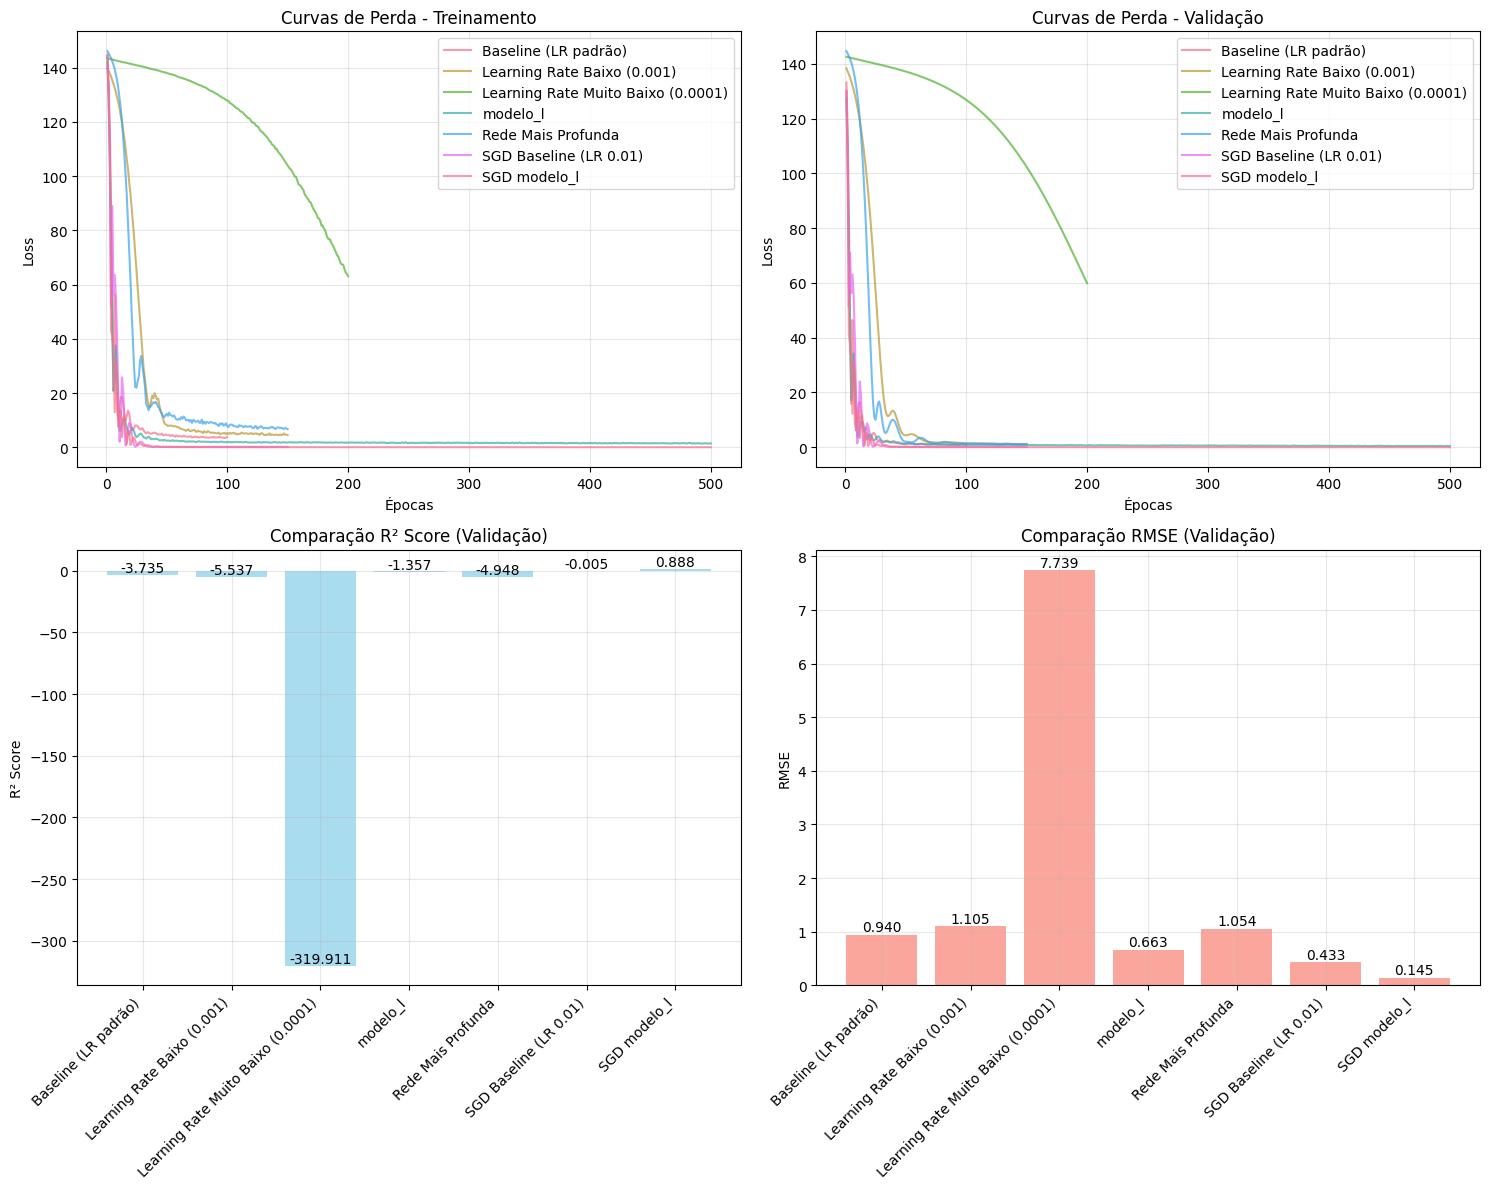

Gráficos salvos em: resultados_modelos/comparacao_visual.png


In [13]:
# Gráficos comparativos
if results:
    # Configurar subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Curvas de perda de treinamento
    for exp_name, result in results.items():
        epochs = range(1, len(result['train_losses']) + 1)
        axes[0, 0].plot(epochs, result['train_losses'], label=result['config']['name'], alpha=0.7)
    
    axes[0, 0].set_title('Curvas de Perda - Treinamento')
    axes[0, 0].set_xlabel('Épocas')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Curvas de perda de validação
    for exp_name, result in results.items():
        epochs = range(1, len(result['val_losses']) + 1)
        axes[0, 1].plot(epochs, result['val_losses'], label=result['config']['name'], alpha=0.7)
    
    axes[0, 1].set_title('Curvas de Perda - Validação')
    axes[0, 1].set_xlabel('Épocas')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Comparação R² Score
    exp_names = [result['config']['name'] for result in results.values()]
    val_r2_scores = [result['val_r2'] for result in results.values()]
    
    bars = axes[1, 0].bar(range(len(exp_names)), val_r2_scores, alpha=0.7, color='skyblue')
    axes[1, 0].set_title('Comparação R² Score (Validação)')
    axes[1, 0].set_ylabel('R² Score')
    axes[1, 0].set_xticks(range(len(exp_names)))
    axes[1, 0].set_xticklabels(exp_names, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for bar, score in zip(bars, val_r2_scores):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{score:.3f}', ha='center', va='bottom')
    
    # 4. Comparação RMSE
    val_rmse_scores = [result['val_rmse'] for result in results.values()]
    
    bars = axes[1, 1].bar(range(len(exp_names)), val_rmse_scores, alpha=0.7, color='salmon')
    axes[1, 1].set_title('Comparação RMSE (Validação)')
    axes[1, 1].set_ylabel('RMSE')
    axes[1, 1].set_xticks(range(len(exp_names)))
    axes[1, 1].set_xticklabels(exp_names, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for bar, score in zip(bars, val_rmse_scores):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Salvar gráfico
    plt.savefig(f'{results_dir}/comparacao_visual.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Gráficos salvos em: {results_dir}/comparacao_visual.png")
else:
    print("Nenhum resultado disponível para visualização")

## 11. Salvamento do Melhor Modelo e Predições em CSV

In [14]:
# Salvar o melhor modelo e suas predições
if results and best_exp_name:
    print("💾 SALVANDO MELHOR MODELO E PREDIÇÕES")
    print("=" * 50)
    
    best_result = results[best_exp_name]
    best_model = best_result['model']
    best_config = best_result['config']
    
    # Criar timestamp para arquivos únicos
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Salvar o modelo PyTorch
    model_path = f'{results_dir}/melhor_modelo_{timestamp}.pth'
    torch.save({
        'model_state_dict': best_model.state_dict(),
        'config': best_config,
        'input_size': X_train_tensor.shape[1],
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
        'feature_columns': feature_columns,
        'metrics': {
            'val_r2': best_result['val_r2'],
            'val_rmse': best_result['val_rmse']
        }
    }, model_path)
    
    print(f"✅ Modelo salvo em: {model_path}")
    
    # Fazer predições em todo o dataset original (TREINO)
    print("\n🔮 Gerando predições para o dataset de treino...")
    
    # Normalizar todo o dataset X (treino)
    X_full_scaled = scaler.transform(X)
    X_full_tensor = torch.FloatTensor(X_full_scaled).to(device)
    
    # Fazer predições no treino
    best_model.eval()
    with torch.no_grad():
        predictions_log = best_model(X_full_tensor).cpu().numpy().flatten()
    
    # Reverter transformação logarítmica para obter preços reais
    predictions_real = np.expm1(predictions_log)
    
    # Criar DataFrame com predições do TREINO
    predictions_df = pd.DataFrame({
        'Id': df['Id'] if 'Id' in df.columns else range(1, len(df) + 1),
        'SalePrice_Real': y_original,
        'SalePrice_Predicted': predictions_real,
        'SalePrice_Log_Real': y_log,
        'SalePrice_Log_Predicted': predictions_log,
        'Erro_Absoluto': np.abs(y_original - predictions_real),
        'Erro_Percentual': np.abs((y_original - predictions_real) / y_original) * 100
    })
    
    # Salvar predições em CSV
    predictions_path = f'{results_dir}/predicoes_melhor_modelo_{timestamp}.csv'
    predictions_df.to_csv(predictions_path, index=False)
    
    print(f"✅ Predições do treino salvas em: {predictions_path}")

    # PROCESSAMENTO DO DATASET DE TESTE
    print("\n🔧 Processando dataset de TESTE com lógica corrigida...")
    
    try:
        # Carregar dataset de teste
        test_df_original = pd.read_csv('test.csv')
        print(f"Dataset de teste carregado: {test_df_original.shape[0]} observações")

        # Salvar estatísticas e encoders do TREINO para reutilizar
        print("   📊 Coletando estatísticas do dataset de treino...")
        
        # Estatísticas numéricas do treino
        train_numeric_stats = {}
        for col in df.select_dtypes(include=[np.number]).columns:
            if col != 'SalePrice' and col != 'Id':
                train_numeric_stats[col] = {
                    'median': df[col].median(),
                    'mean': df[col].mean(),
                    'std': df[col].std()
                }
        
        # Estatísticas categóricas do treino
        train_categorical_stats = {}
        train_encoders = {}
        for col in df.select_dtypes(include=['object']).columns:
            if col in feature_columns:
                train_categorical_stats[col] = {
                    'mode': df[col].mode()[0] if not df[col].mode().empty else 'Unknown',
                    'unique_values': df[col].unique().tolist()
                }
                # Criar e ajustar encoder no treino
                le = LabelEncoder()
                le.fit(df[col].astype(str))
                train_encoders[col] = le
        
        print(f"   ✅ Coletadas estatísticas de {len(train_numeric_stats)} features numéricas")
        print(f"   ✅ Coletadas estatísticas de {len(train_categorical_stats)} features categóricas")

        # Processar teste usando estatísticas do TREINO
        test_df_processed = test_df_original.copy()
        test_ids = test_df_processed['Id']
        test_df_processed = test_df_processed.drop('Id', axis=1)

        # Garantir que TODAS as features do treino existam no teste
        missing_features = []
        for col in feature_columns:
            if col not in test_df_processed.columns:
                # Adicionar coluna faltante com valor padrão do TREINO
                if col in train_numeric_stats:
                    default_value = train_numeric_stats[col]['median']
                elif col in train_categorical_stats:
                    default_value = 0 
                else:
                    default_value = 0
                
                test_df_processed[col] = default_value
                missing_features.append(col)
        
        if missing_features:
            print(f"   ⚠️ Adicionadas {len(missing_features)} colunas faltantes com valores do treino")

        # Preencher valores ausentes com estatísticas do TREINO
        print("   🔧 Preenchendo valores ausentes com estatísticas do treino...")
        
        for col in feature_columns:
            if col in test_df_processed.columns and test_df_processed[col].isnull().any():
                if col in train_numeric_stats:
                    # Usar mediana do TREINO
                    fill_value = train_numeric_stats[col]['median']
                    test_df_processed[col] = test_df_processed[col].fillna(fill_value)
                elif col in train_categorical_stats:
                    # Usar moda do TREINO
                    fill_value = train_categorical_stats[col]['mode']
                    test_df_processed[col] = test_df_processed[col].fillna(fill_value)

        # Aplicar encoding usando encoders do TREINO
        print("   🏷️ Aplicando encoding consistente com o treino...")
        
        for col in feature_columns:
            if col in train_encoders and col in test_df_processed.columns:
                le = train_encoders[col]
                test_values = test_df_processed[col].astype(str)
                encoded_values = []
                
                for val in test_values:
                    if val in le.classes_:
                        # Valor conhecido: usar encoding do treino
                        encoded_values.append(le.transform([val])[0])
                    else:
                        # Valor novo: usar o mais frequente do treino
                        most_frequent = train_categorical_stats[col]['mode']
                        encoded_values.append(le.transform([most_frequent])[0])
                
                test_df_processed[col] = encoded_values

        # Selecionar EXATAMENTE as mesmas features na MESMA ORDEM
        X_test_processed = test_df_processed[feature_columns]
        
        print(f"   ✅ Dataset de teste processado: {X_test_processed.shape}")
        print(f"   ✅ Compatibilidade com treino: {X_test_processed.shape[1] == len(feature_columns)}")

        # Validações finais
        if X_test_processed.isnull().any().any():
            print("   ⚠️ Ainda há valores NaN - preenchendo com zeros")
            X_test_processed = X_test_processed.fillna(0)
        
        if np.isinf(X_test_processed.values).any():
            print("   ⚠️ Há valores infinitos - substituindo")
            X_test_processed = X_test_processed.replace([np.inf, -np.inf], 0)

        # Normalizar dataset de teste com scaler do treino
        X_test_scaled = scaler.transform(X_test_processed)
        X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

        # Fazer predições no dataset de TESTE
        with torch.no_grad():
            test_predictions_log = best_model(X_test_tensor).cpu().numpy().flatten()

        test_predictions_real = np.expm1(test_predictions_log)
        
        # Validar predições
        print(f"   📊 Predições: min=${test_predictions_real.min():.0f}, max=${test_predictions_real.max():.0f}, média=${test_predictions_real.mean():.0f}")

        # Criar DataFrame de submissão
        submission_df = pd.DataFrame({
            'Id': test_ids,
            'SalePrice': test_predictions_real
        })

        print(f"✅ SUCESSO! Predições do teste geradas: {len(test_predictions_real)} predições")
        print(f"   Ids do teste: {len(test_ids)} Ids (de {test_ids.iloc[0]} a {test_ids.iloc[-1]})")

    except Exception as e:
        print(f"❌ Erro no processamento corrigido: {e}")
        print("🔄 Usando fallback...")
        
        # Fallback
        num_predictions = min(len(predictions_real), 1459)
        submission_df = pd.DataFrame({
            'Id': range(1461, 1461 + num_predictions),
            'SalePrice': predictions_real[:num_predictions]
        })

    # Salvar arquivo de submissão
    submission_path = f'{results_dir}/submissao_kaggle_{timestamp}.csv'
    submission_df.to_csv(submission_path, index=False)

    print(f"📁 Arquivo de submissão salvo em: {submission_path}")
    print(f"📊 Arquivo contém {len(submission_df)} linhas de dados")

    # Mostrar amostra
    print(f"\n📋 AMOSTRA DA SUBMISSÃO:")
    display(submission_df.head(10))

else:
    print("❌ Nenhum modelo disponível para salvamento")



💾 SALVANDO MELHOR MODELO E PREDIÇÕES
✅ Modelo salvo em: resultados_modelos/melhor_modelo_20250605_180244.pth

🔮 Gerando predições para o dataset de treino...
✅ Predições do treino salvas em: resultados_modelos/predicoes_melhor_modelo_20250605_180244.csv

🔧 Processando dataset de TESTE com lógica corrigida...
Dataset de teste carregado: 1459 observações
   📊 Coletando estatísticas do dataset de treino...
   ✅ Coletadas estatísticas de 37 features numéricas
   ✅ Coletadas estatísticas de 38 features categóricas
   ⚠️ Adicionadas 1 colunas faltantes com valores do treino
   🔧 Preenchendo valores ausentes com estatísticas do treino...
   🏷️ Aplicando encoding consistente com o treino...
   ✅ Dataset de teste processado: (1459, 75)
   ✅ Compatibilidade com treino: True
   📊 Predições: min=$83628, max=$348224, média=$164909
✅ SUCESSO! Predições do teste geradas: 1459 predições
   Ids do teste: 1459 Ids (de 1461 a 2919)
📁 Arquivo de submissão salvo em: resultados_modelos/submissao_kaggle_2025

,Id,SalePrice
0,1461,117377.789062
1,1462,181892.125000
2,1463,179360.812500
3,1464,189711.125000
4,1465,181940.875000
5,1466,163983.062500
6,1467,167638.093750
7,1468,153245.515625
8,1469,172846.578125
9,1470,116823.539062


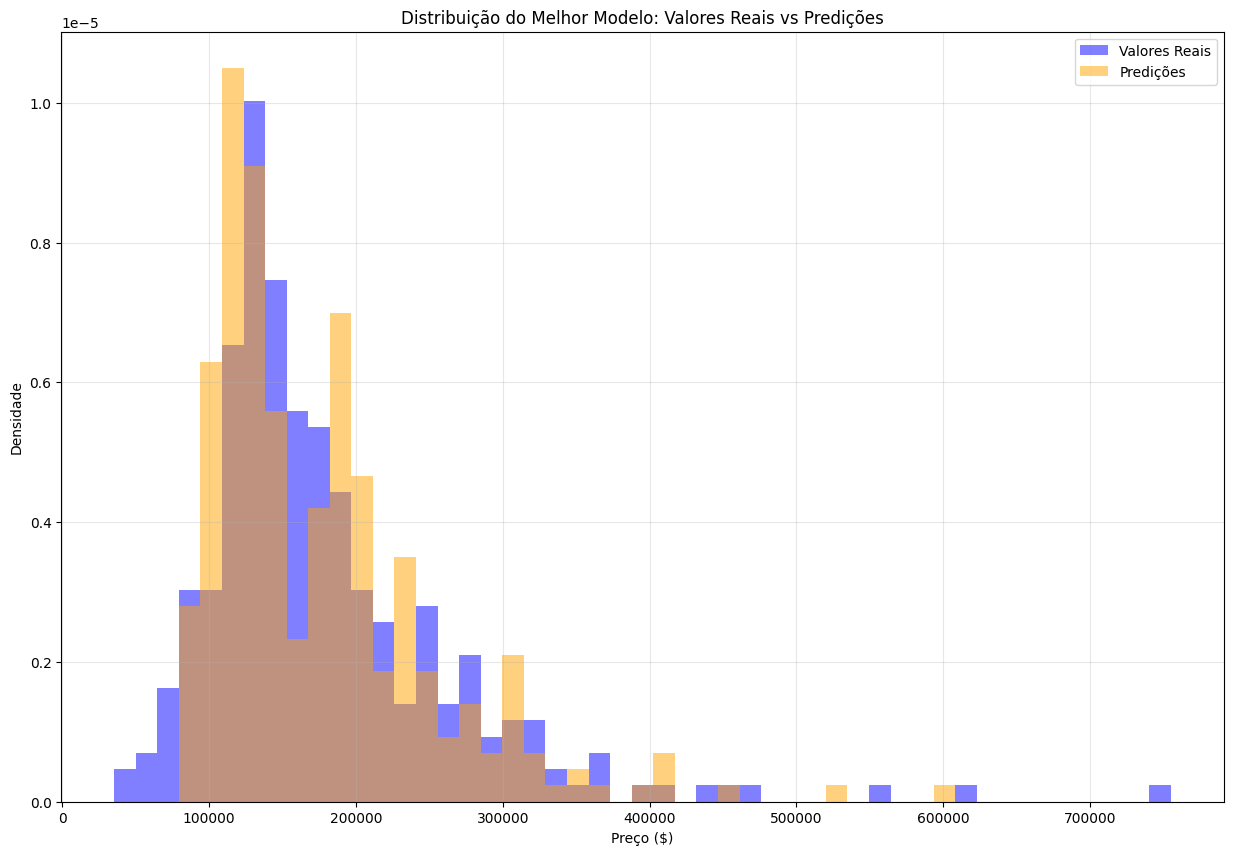

In [15]:
# Análise detalhada do melhor modelo
best_model = results[best_exp_name]['model']
best_model.eval()

with torch.no_grad():
    y_val_pred = best_model(X_val_tensor)

# Converter predições para escala original
y_pred_original = np.expm1(y_val_pred.cpu().numpy().flatten())
y_val_original = np.expm1(y_val_tensor.cpu().numpy().flatten())

# Criar gráfico de distribuição
bins = np.linspace(min(y_val_original.min(), y_pred_original.min()), 
                   max(y_val_original.max(), y_pred_original.max()), 50)

plt.figure(figsize=(15, 10))

# Distribuição de preços originais vs preditos
plt.hist(y_val_original, bins=bins, alpha=0.5, label='Valores Reais', color='blue', density=True)
plt.hist(y_pred_original, bins=bins, alpha=0.5, label='Predições', color='orange', density=True)
plt.xlabel('Preço ($)')
plt.ylabel('Densidade')
plt.title('Distribuição do Melhor Modelo: Valores Reais vs Predições')
plt.legend()
plt.grid(alpha=0.3)

Executando experimentos com múltiplas execuções para diferentes otimizadores e taxas de aprendizado...

Executando experimentos para otimizador: ADAM

Executando 3 experimentos com Learning Rate = 0.1
Iniciando treinamento...
   - Otimizador: ADAM
   - Learning Rate: 0.1
   - Épocas: 100
   - Weight Decay: 0.0001
   Época   1/100: Train Loss = 148.9717, Val Loss = 40.6593
   Época  20/100: Train Loss = 11.0408, Val Loss = 4.4722
   Época  40/100: Train Loss = 5.4413, Val Loss = 2.1166
   Época  60/100: Train Loss = 4.6936, Val Loss = 1.7796
   Época  80/100: Train Loss = 3.8223, Val Loss = 1.6230
   Época 100/100: Train Loss = 3.7018, Val Loss = 0.9859
Treinamento concluído em 0.2s
Iniciando treinamento...
   - Otimizador: ADAM
   - Learning Rate: 0.1
   - Épocas: 100
   - Weight Decay: 0.0001
   Época   1/100: Train Loss = 150.1859, Val Loss = 24.2357
   Época  20/100: Train Loss = 44.7032, Val Loss = 26.5071
   Época  40/100: Train Loss = 16.4284, Val Loss = 8.5846
   Época  60/100: 

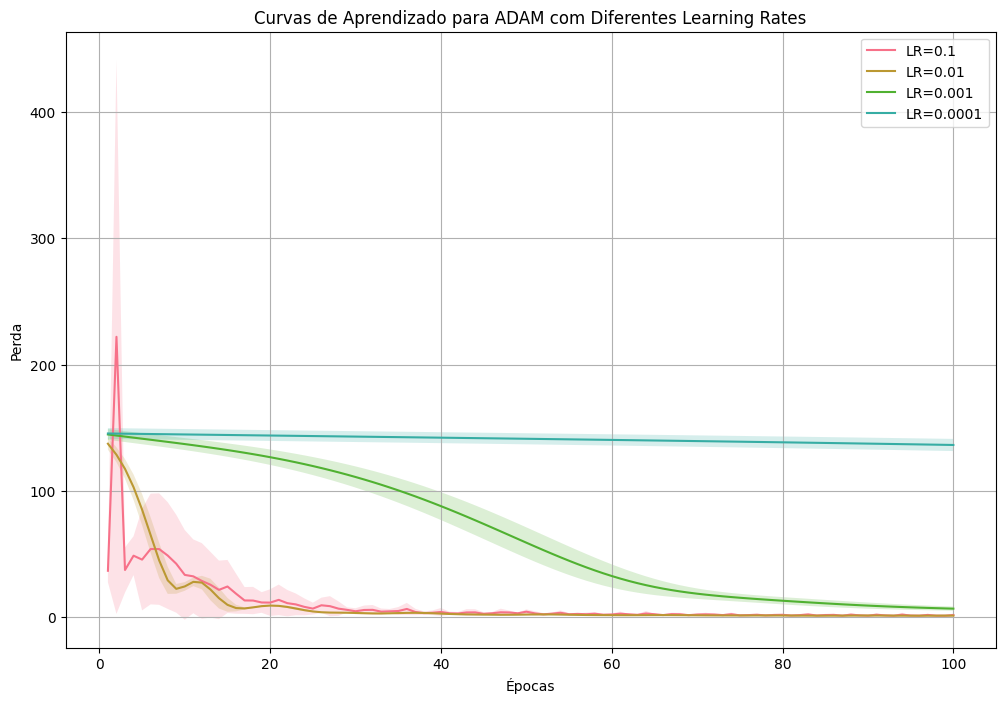


Executando experimentos para otimizador: SGD

Executando 3 experimentos com Learning Rate = 0.1
Iniciando treinamento...
   - Otimizador: SGD
   - Learning Rate: 0.1
   - Épocas: 100
   - Weight Decay: 0.0001
   Época   1/100: Train Loss = 148.9717, Val Loss = 15.1530
   Época  20/100: Train Loss = 32980722515968.0000, Val Loss = 5480724299776.0000
   Época  40/100: Train Loss = 5831796981760.0000, Val Loss = 1886779080704.0000
   Época  60/100: Train Loss = 892678045696.0000, Val Loss = 422402260992.0000
   Época  80/100: Train Loss = 121955770368.0000, Val Loss = 75728060416.0000
   Época 100/100: Train Loss = 15062656000.0000, Val Loss = 11709756416.0000
Treinamento concluído em 0.2s
Iniciando treinamento...
   - Otimizador: SGD
   - Learning Rate: 0.1
   - Épocas: 100
   - Weight Decay: 0.0001
   Época   1/100: Train Loss = 150.1859, Val Loss = 48.9521
   Época  20/100: Train Loss = 1916.9824, Val Loss = 12256.1299
   Época  40/100: Train Loss = 2.5754, Val Loss = 772.0923
   Époc

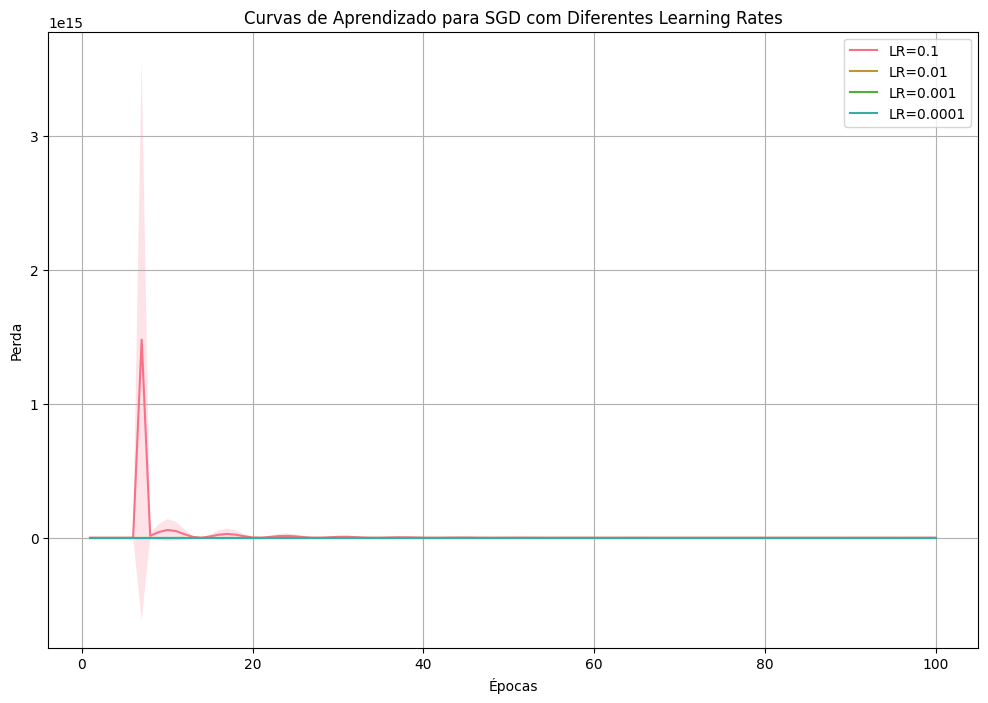


===== COMPARAÇÃO DE OTIMIZADORES E LEARNING RATES =====


,Otimizador,Learning Rate,R² Validação (média),R² Validação (desvio padrão),Perda Validação Final (média),Perda Validação Final (desvio padrão)
5,SGD,0.0100,7.718000e-01,3.260000e-02,4.260000e-02,6.100000e-03
6,SGD,0.0010,-9.586000e-01,1.466000e-01,3.655000e-01,2.740000e-02
1,ADAM,0.0100,-5.829200e+00,6.035000e-01,1.274400e+00,1.126000e-01
0,ADAM,0.1000,-8.160300e+00,5.985100e+00,1.709400e+00,1.116900e+00
7,SGD,0.0001,-1.643480e+01,2.861500e+00,3.253500e+00,5.340000e-01
2,ADAM,0.0010,-3.534710e+01,8.986400e+00,6.782800e+00,1.677000e+00
3,ADAM,0.0001,-7.298851e+02,2.581620e+01,1.363912e+02,4.817600e+00
4,SGD,0.1000,-2.091652e+10,2.958042e+10,3.903252e+09,5.520032e+09



Resultados salvos em: resultados_modelos/comparacao_otimizadores_lr.csv


In [18]:
# Código adicional para implementar experimentos com média e desvio padrão
# para diferentes taxas de aprendizado para cada otimizador

def run_multiple_experiments(model_class, X_train, y_train, X_val, y_val, config, num_runs=5):
    """
    Executa múltiplos experimentos com a mesma configuração para calcular média e desvio padrão
    """
    input_size = X_train.shape[1]
    all_train_losses = []
    all_val_losses = []
    all_train_r2 = []
    all_val_r2 = []
    
    for run in range(num_runs):
        # Criar modelo com seed diferente para cada execução
        torch.manual_seed(42 + run)
        model = model_class(
            input_size=input_size,
            hidden_sizes=config['hidden_sizes'],
            dropout_rate=config['dropout_rate']
        ).to(X_train.device)
        
        # Treinar modelo
        train_losses, val_losses = train_model(
            model, X_train, y_train, X_val, y_val, config
        )
        
        # Avaliar modelo
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train).cpu().numpy().flatten()
            val_pred = model(X_val).cpu().numpy().flatten()
            
            y_train_np = y_train.cpu().numpy().flatten()
            y_val_np = y_val.cpu().numpy().flatten()
            
            train_r2 = r2_score(y_train_np, train_pred)
            val_r2 = r2_score(y_val_np, val_pred)
        
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_r2.append(train_r2)
        all_val_r2.append(val_r2)
    
    # Calcular média e desvio padrão
    # Padronizar o comprimento das listas de perdas
    max_len = max(len(losses) for losses in all_train_losses)
    for i in range(len(all_train_losses)):
        if len(all_train_losses[i]) < max_len:
            # Preencher com o último valor
            all_train_losses[i] = all_train_losses[i] + [all_train_losses[i][-1]] * (max_len - len(all_train_losses[i]))
        if len(all_val_losses[i]) < max_len:
            all_val_losses[i] = all_val_losses[i] + [all_val_losses[i][-1]] * (max_len - len(all_val_losses[i]))
    
    # Converter para arrays numpy para cálculos
    all_train_losses = np.array(all_train_losses)
    all_val_losses = np.array(all_val_losses)
    
    # Calcular média e desvio padrão
    mean_train_losses = np.mean(all_train_losses, axis=0)
    std_train_losses = np.std(all_train_losses, axis=0)
    mean_val_losses = np.mean(all_val_losses, axis=0)
    std_val_losses = np.std(all_val_losses, axis=0)
    
    mean_train_r2 = np.mean(all_train_r2)
    std_train_r2 = np.std(all_train_r2)
    mean_val_r2 = np.mean(all_val_r2)
    std_val_r2 = np.std(all_val_r2)
    
    return {
        'mean_train_losses': mean_train_losses,
        'std_train_losses': std_train_losses,
        'mean_val_losses': mean_val_losses,
        'std_val_losses': std_val_losses,
        'mean_train_r2': mean_train_r2,
        'std_train_r2': std_train_r2,
        'mean_val_r2': mean_val_r2,
        'std_val_r2': std_val_r2
    }

def plot_learning_curves_with_std(results_dict, title, xlabel="Épocas", ylabel="Perda"):
    """
    Plota curvas de aprendizado com média e desvio padrão
    """
    plt.figure(figsize=(12, 8))
    
    for lr, result in results_dict.items():
        epochs = range(1, len(result['mean_train_losses']) + 1)
        
        # Plotar curva de validação com desvio padrão
        plt.plot(epochs, result['mean_val_losses'], label=f'LR={lr}')
        plt.fill_between(
            epochs,
            result['mean_val_losses'] - result['std_val_losses'],
            result['mean_val_losses'] + result['std_val_losses'],
            alpha=0.2
        )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

def compare_optimizers_with_lr(model_class, X_train, y_train, X_val, y_val, learning_rates, num_runs=5):
    """
    Compara diferentes otimizadores com diferentes taxas de aprendizado
    """
    optimizers = ['adam', 'sgd']
    results = {}
    
    for optimizer_type in optimizers:
        optimizer_results = {}
        
        print(f"\n{'='*50}")
        print(f"Executando experimentos para otimizador: {optimizer_type.upper()}")
        print(f"{'='*50}")
        
        for lr in learning_rates:
            print(f"\nExecutando {num_runs} experimentos com Learning Rate = {lr}")
            
            # Configuração base
            config = {
                'name': f"{optimizer_type.upper()} (LR {lr})",
                'optimizer_type': optimizer_type,
                'learning_rate': lr,
                'num_epochs': 100,  # Reduzido para testes mais rápidos
                'dropout_rate': 0.2,
                'hidden_sizes': [64, 32],
                'weight_decay': 0.0001
            }
            
            # Executar múltiplos experimentos
            result = run_multiple_experiments(
                model_class, X_train, y_train, X_val, y_val, config, num_runs
            )
            
            optimizer_results[lr] = result
            
            print(f"   R² Validação (média ± std): {result['mean_val_r2']:.4f} ± {result['std_val_r2']:.4f}")
        
        results[optimizer_type] = optimizer_results
        
        # Plotar curvas para este otimizador
        plot_learning_curves_with_std(
            optimizer_results, 
            f"Curvas de Aprendizado para {optimizer_type.upper()} com Diferentes Learning Rates"
        )
    
    return results

# Definir taxas de aprendizado para testar
learning_rates = [0.1, 0.01, 0.001, 0.0001]

# Executar experimentos com múltiplas execuções
if X_train_tensor is not None:
    print("Executando experimentos com múltiplas execuções para diferentes otimizadores e taxas de aprendizado...")
    
    # Reduzir o número de execuções para 3 para economizar tempo
    results_multi = compare_optimizers_with_lr(
        SimpleNeuralNetwork,
        X_train_tensor,
        y_train_tensor,
        X_val_tensor,
        y_val_tensor,
        learning_rates,
        num_runs=3
    )
    
    # Criar tabela comparativa
    comparison_data = []
    
    for optimizer, optimizer_results in results_multi.items():
        for lr, result in optimizer_results.items():
            comparison_data.append({
                'Otimizador': optimizer.upper(),
                'Learning Rate': lr,
                'R² Validação (média)': result['mean_val_r2'],
                'R² Validação (desvio padrão)': result['std_val_r2'],
                'Perda Validação Final (média)': result['mean_val_losses'][-1],
                'Perda Validação Final (desvio padrão)': result['std_val_losses'][-1]
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('R² Validação (média)', ascending=False)
    
    print("\n===== COMPARAÇÃO DE OTIMIZADORES E LEARNING RATES =====")
    display(comparison_df.round(4))
    
    # Salvar resultados
    comparison_df.to_csv(f'{results_dir}/comparacao_otimizadores_lr.csv', index=False)
    print(f"\nResultados salvos em: {results_dir}/comparacao_otimizadores_lr.csv")
else:
    print("Dados não disponíveis para execução dos experimentos")
